# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn, \
    torch.nn.functional as F, \
    torch.optim as optim, \
    torch.autograd as autograd, \
    torch.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import mnist

In [2]:
gpu = torch.device('cuda:0')
cpu = torch.device('cpu')
torch.cuda.get_device_name(device=gpu)

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\cuda\__init__.py:87: UserWarning: 
    Found GPU1 GeForce GTX 650 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


'GeForce GTX 1070'

In [3]:
X_train, y_train = torch.tensor(mnist.train_images()), torch.tensor(mnist.train_labels())
X_test, y_test = torch.tensor(mnist.test_images()), torch.tensor(mnist.test_labels())

X_train = (X_train.float()/255).unsqueeze(dim=1).to(gpu)
X_test = (X_test.float()/255).unsqueeze(dim=1).to(gpu)

y_train_onehot = F.one_hot(y_train.to(torch.int64)).float().to(gpu)
y_test_onehot = F.one_hot(y_test.to(torch.int64)).float().to(gpu)

In [4]:
print(X_train.shape,'\n',
     X_test.shape,'\n',
     y_train_onehot.shape,'\n',
     y_test_onehot.shape, sep='')

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([60000, 10])
torch.Size([10000, 10])


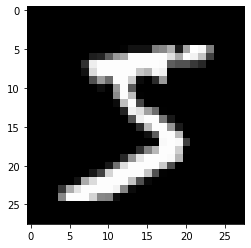

In [5]:
plt.imshow(X_train.to(cpu)[0][0], 'gray');

**Create dataloader object**

In [6]:
class torchData(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), 'X, y have different lengths'
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
dataset = torchData(X_train, y_train_onehot)
dataloader = DataLoader(dataset=dataset, batch_size=64)

**Design network**

In [8]:
channels = [4, 8]
pool_kernels = [3, 3]
out_dim = 28 - 2*len(channels) - sum([i-1 for i in pool_kernels])

class model(nn.Module):
    def __init__(self):
        # Inheriting nn.Module to convert this to a pytorch NN
        # All functionality of nn.Module; module base class keeps track of all weights
        super(model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = channels[0], kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels = channels[0], out_channels = channels[1], kernel_size=3, stride=1)
#         self.conv3 = nn.Conv2d(in_channels = channels[1], out_channels = channels[2], kernel_size=3, stride=1)
#         self.conv4 = nn.Conv2d(in_channels = channels[2], out_channels = channels[3], kernel_size=3, stride=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernels[0], stride=1, padding=0, ceil_mode=True)
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernels[1], stride=1, padding=0, ceil_mode=True)
#         self.pool3 = nn.MaxPool2d(kernel_size = pool_kernels[2], stride=1, padding=0, ceil_mode=True)
#         self.pool4 = nn.MaxPool2d(kernel_size = pool_kernels[3], stride=1, padding=0, ceil_mode=True)
        
        self.dropout1 = nn.Dropout2d(.25)
        self.dropout2 = nn.Dropout2d(.25)
#         self.dropout3 = nn.Dropout2d(.25)
#         self.dropout4 = nn.Dropout2d(p=.25)
        self.dropout_dense = nn.Dropout2d(.25)
        
        self.batchnorm1 = nn.BatchNorm2d(channels[0])
        self.batchnorm2 = nn.BatchNorm2d(channels[1])
#         self.batchnorm3 = nn.BatchNorm2d(channels[2])
#         self.batchnorm4 = nn.BatchNorm2d(channels[3])
        
        self.dense1 = nn.Linear(in_features = (channels[-1]*out_dim*out_dim), out_features = 32)
        self.dense2 = nn.Linear(in_features=32, out_features = 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.batchnorm1(self.dropout1(self.conv1(x)))))
        x = self.pool2(F.relu(self.batchnorm2(self.dropout2(self.conv2(x)))))
#         x = self.pool3(F.relu(self.batchnorm3(self.dropout3(self.conv3(x)))))
#         x = self.pool4(F.relu(self.batchnorm4(self.dropout1(self.conv4(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout_dense(self.dense1(x)))
        x = F.relu(self.dense2(x))
        output = F.softmax(x, dim=1)
        return x

### Implementation A (MSE Loss)

**Define loss function and optimizer**

In [35]:
cnn = model().to(gpu)

criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr = 1e-4)

**Train model**

In [36]:
total_loss = 0
for epoch in range(50):
    epoch_loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        total_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {i+1} \n',f'Epoch Loss: {epoch_loss/(i+1)} \n',
                  f'Total Loss: {total_loss/((i+1)*(epoch+1))} \n', sep='')
print('Complete')

Epoch: 1, Batch: 100 
Epoch Loss: 0.08562730520963668 
Total Loss: 0.08562730520963668 

Epoch: 1, Batch: 200 
Epoch Loss: 0.07593702983111143 
Total Loss: 0.07593702983111143 

Epoch: 1, Batch: 300 
Epoch Loss: 0.07055833879858256 
Total Loss: 0.07055833879858256 

Epoch: 1, Batch: 400 
Epoch Loss: 0.06647306262515486 
Total Loss: 0.06647306262515486 

Epoch: 1, Batch: 500 
Epoch Loss: 0.06356062172353268 
Total Loss: 0.06356062172353268 

Epoch: 1, Batch: 600 
Epoch Loss: 0.061036350329717 
Total Loss: 0.061036350329717 

Epoch: 1, Batch: 700 
Epoch Loss: 0.05895128623183284 
Total Loss: 0.05895128623183284 

Epoch: 1, Batch: 800 
Epoch Loss: 0.0572998766368255 
Total Loss: 0.0572998766368255 

Epoch: 1, Batch: 900 
Epoch Loss: 0.05537891140000688 
Total Loss: 0.05537891140000688 

Epoch: 2, Batch: 100 
Epoch Loss: 0.03644070323556661 
Total Loss: 0.27417651682160793 

Epoch: 2, Batch: 200 
Epoch Loss: 0.03636531507596374 
Total Loss: 0.1461607401398942 

Epoch: 2, Batch: 300 
Epoch 

Epoch: 11, Batch: 300 
Epoch Loss: 0.019881258591388663 
Total Loss: 0.08120088951097745 

Epoch: 11, Batch: 400 
Epoch Loss: 0.019762383261695503 
Total Loss: 0.06134170707124709 

Epoch: 11, Batch: 500 
Epoch Loss: 0.019819039393216373 
Total Loss: 0.049437832273712214 

Epoch: 11, Batch: 600 
Epoch Loss: 0.019804058127726117 
Total Loss: 0.04149712010385525 

Epoch: 11, Batch: 700 
Epoch Loss: 0.019878739496426923 
Total Loss: 0.03583294486445556 

Epoch: 11, Batch: 800 
Epoch Loss: 0.01998932843678631 
Total Loss: 0.03158977506343614 

Epoch: 11, Batch: 900 
Epoch Loss: 0.01984323381860223 
Total Loss: 0.028268431135914242 

Epoch: 12, Batch: 100 
Epoch Loss: 0.018772097621113062 
Total Loss: 0.2353348688253512 

Epoch: 12, Batch: 200 
Epoch Loss: 0.019335021069273352 
Total Loss: 0.11849651543423534 

Epoch: 12, Batch: 300 
Epoch Loss: 0.019462189295639594 
Total Loss: 0.079545358226945 

Epoch: 12, Batch: 400 
Epoch Loss: 0.019300339496694505 
Total Loss: 0.06005099346395582 

Ep

Epoch: 21, Batch: 400 
Epoch Loss: 0.016169039299711585 
Total Loss: 0.05208207047228435 

Epoch: 21, Batch: 500 
Epoch Loss: 0.016159675138071178 
Total Loss: 0.04181920131584186 

Epoch: 21, Batch: 600 
Epoch Loss: 0.016047940747812392 
Total Loss: 0.03497226513460249 

Epoch: 21, Batch: 700 
Epoch Loss: 0.016115303570404648 
Total Loss: 0.030088604676638583 

Epoch: 21, Batch: 800 
Epoch Loss: 0.016298252200940624 
Total Loss: 0.026432165357622408 

Epoch: 21, Batch: 900 
Epoch Loss: 0.016153116068906254 
Total Loss: 0.02357458098991109 

Epoch: 22, Batch: 100 
Epoch Loss: 0.01538117203861475 
Total Loss: 0.20345448197246613 

Epoch: 22, Batch: 200 
Epoch Loss: 0.016082462312188 
Total Loss: 0.10210868990863674 

Epoch: 22, Batch: 300 
Epoch Loss: 0.016012881852996846 
Total Loss: 0.06831297086234289 

Epoch: 22, Batch: 400 
Epoch Loss: 0.01585817292914726 
Total Loss: 0.05140966048945715 

Epoch: 22, Batch: 500 
Epoch Loss: 0.015893180892802776 
Total Loss: 0.041273484871087764 

E

Epoch: 31, Batch: 500 
Epoch Loss: 0.014483622153289617 
Total Loss: 0.03744521901619831 

Epoch: 31, Batch: 600 
Epoch Loss: 0.014455382369148234 
Total Loss: 0.031281307155694514 

Epoch: 31, Batch: 700 
Epoch Loss: 0.014453606279566884 
Total Loss: 0.02687910636267861 

Epoch: 31, Batch: 800 
Epoch Loss: 0.014558981549344025 
Total Loss: 0.023580897940076784 

Epoch: 31, Batch: 900 
Epoch Loss: 0.014429801714399622 
Total Loss: 0.021008813807074863 

Epoch: 32, Batch: 100 
Epoch Loss: 0.013744338061660527 
Total Loss: 0.18374931592588836 

Epoch: 32, Batch: 200 
Epoch Loss: 0.014524659926537424 
Total Loss: 0.09211379830343504 

Epoch: 32, Batch: 300 
Epoch Loss: 0.014551559234969319 
Total Loss: 0.06156133801324662 

Epoch: 32, Batch: 400 
Epoch Loss: 0.014258413420757279 
Total Loss: 0.046275526759764034 

Epoch: 32, Batch: 500 
Epoch Loss: 0.014356448165141046 
Total Loss: 0.037112600077452956 

Epoch: 32, Batch: 600 
Epoch Loss: 0.014232050147062789 
Total Loss: 0.03099805246067

Epoch: 41, Batch: 500 
Epoch Loss: 0.013432567716110498 
Total Loss: 0.03459665236582343 

Epoch: 41, Batch: 600 
Epoch Loss: 0.01342495329095982 
Total Loss: 0.028884961854304923 

Epoch: 41, Batch: 700 
Epoch Loss: 0.013469759087144796 
Total Loss: 0.024806408397293606 

Epoch: 41, Batch: 800 
Epoch Loss: 0.01356330170208821 
Total Loss: 0.021748955213505967 

Epoch: 41, Batch: 900 
Epoch Loss: 0.013509608838034587 
Total Loss: 0.01936785196735925 

Epoch: 42, Batch: 100 
Epoch Loss: 0.013070436539128422 
Total Loss: 0.17057394791045227 

Epoch: 42, Batch: 200 
Epoch Loss: 0.013476349092088639 
Total Loss: 0.08545223897481005 

Epoch: 42, Batch: 300 
Epoch Loss: 0.013649798769814273 
Total Loss: 0.057079244222296106 

Epoch: 42, Batch: 400 
Epoch Loss: 0.013525205057812855 
Total Loss: 0.04288771545197094 

Epoch: 42, Batch: 500 
Epoch Loss: 0.01348577475361526 
Total Loss: 0.03437363928318068 

Epoch: 42, Batch: 600 
Epoch Loss: 0.013437191746973743 
Total Loss: 0.02869705764357821 

### Implementation B (Cross-Entropy Loss)

**Define loss function and optimizer**

In [40]:
cnn2 = model().to(gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn2.parameters(), lr = 1e-4)

**Train model**

In [41]:
total_loss = 0
for epoch in range(50):
    epoch_loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        labels = labels.argmax(dim=1).long()
        optimizer.zero_grad()
        
        outputs = cnn2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        total_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {i+1} \n', f'Epoch Loss: {epoch_loss/(i+1)} \n',
                  f'Total Loss: {total_loss/((i+1)*(epoch+1))} \n', sep='')
print('Complete')

Epoch: 1, Batch: 100 
Epoch Loss: 2.0997710359096526 
Total Loss: 2.0997710359096526 

Epoch: 1, Batch: 200 
Epoch Loss: 1.9590588796138764 
Total Loss: 1.9590588796138764 

Epoch: 1, Batch: 300 
Epoch Loss: 1.8169571097691855 
Total Loss: 1.8169571097691855 

Epoch: 1, Batch: 400 
Epoch Loss: 1.7041906115412713 
Total Loss: 1.7041906115412713 

Epoch: 1, Batch: 500 
Epoch Loss: 1.61875761449337 
Total Loss: 1.61875761449337 

Epoch: 1, Batch: 600 
Epoch Loss: 1.5461543948451677 
Total Loss: 1.5461543948451677 

Epoch: 1, Batch: 700 
Epoch Loss: 1.4828795105218888 
Total Loss: 1.4828795105218888 

Epoch: 1, Batch: 800 
Epoch Loss: 1.4217936097085475 
Total Loss: 1.4217936097085475 

Epoch: 1, Batch: 900 
Epoch Loss: 1.3624378943443298 
Total Loss: 1.3624378943443298 

Epoch: 2, Batch: 100 
Epoch Loss: 0.801836286187172 
Total Loss: 6.678309253305197 

Epoch: 2, Batch: 200 
Epoch Loss: 0.8056947042047977 
Total Loss: 3.5415429072082043 

Epoch: 2, Batch: 300 
Epoch Loss: 0.7837616195281

Epoch: 11, Batch: 600 
Epoch Loss: 0.24742854225138824 
Total Loss: 0.6599076142274972 

Epoch: 11, Batch: 700 
Epoch Loss: 0.24770517086344107 
Total Loss: 0.568873603656501 

Epoch: 11, Batch: 800 
Epoch Loss: 0.25094713548198344 
Total Loss: 0.500873958742754 

Epoch: 11, Batch: 900 
Epoch Loss: 0.2490140143616332 
Total Loss: 0.44758037792688066 

Epoch: 12, Batch: 100 
Epoch Loss: 0.22140891961753367 
Total Loss: 3.7170882211253047 

Epoch: 12, Batch: 200 
Epoch Loss: 0.23673139013350009 
Total Loss: 1.86904635475638 

Epoch: 12, Batch: 300 
Epoch Loss: 0.23910222813487053 
Total Loss: 1.2528043449525204 

Epoch: 12, Batch: 400 
Epoch Loss: 0.2342994378041476 
Total Loss: 0.9441843226063065 

Epoch: 12, Batch: 500 
Epoch Loss: 0.23705354257673025 
Total Loss: 0.7594819574461629 

Epoch: 12, Batch: 600 
Epoch Loss: 0.23870948203528922 
Total Loss: 0.6363320364735814 

Epoch: 12, Batch: 700 
Epoch Loss: 0.23860660845147713 
Total Loss: 0.5482606665838865 

Epoch: 12, Batch: 800 
Epo

Epoch: 21, Batch: 900 
Epoch Loss: 0.20366865950740046 
Total Loss: 0.342490239763662 

Epoch: 22, Batch: 100 
Epoch Loss: 0.1934474064782262 
Total Loss: 2.9542064213854347 

Epoch: 22, Batch: 200 
Epoch Loss: 0.2050561302341521 
Total Loss: 1.4820274119197645 

Epoch: 22, Batch: 300 
Epoch Loss: 0.20495798175533614 
Total Loss: 0.9911207243828385 

Epoch: 22, Batch: 400 
Epoch Loss: 0.20395699480548501 
Total Loss: 0.7456241118548099 

Epoch: 22, Batch: 500 
Epoch Loss: 0.2065215060710907 
Total Loss: 0.5984700126759708 

Epoch: 22, Batch: 600 
Epoch Loss: 0.2064864024768273 
Total Loss: 0.5002879718095629 

Epoch: 22, Batch: 700 
Epoch Loss: 0.2045779228795852 
Total Loss: 0.43007233327375605 

Epoch: 22, Batch: 800 
Epoch Loss: 0.20569626858923584 
Total Loss: 0.3775265000722456 

Epoch: 22, Batch: 900 
Epoch Loss: 0.20434932550622356 
Total Loss: 0.3365567565331179 

Epoch: 23, Batch: 100 
Epoch Loss: 0.18837066501379013 
Total Loss: 2.908105827803197 

Epoch: 23, Batch: 200 
Epoc

Epoch: 32, Batch: 300 
Epoch Loss: 0.17895042213300863 
Total Loss: 0.8656783267968179 

Epoch: 32, Batch: 400 
Epoch Loss: 0.17752181902527808 
Total Loss: 0.650612151423411 

Epoch: 32, Batch: 500 
Epoch Loss: 0.179434325709939 
Total Loss: 0.5216589983415324 

Epoch: 32, Batch: 600 
Epoch Loss: 0.18049874822298687 
Total Loss: 0.43568364893454903 

Epoch: 32, Batch: 700 
Epoch Loss: 0.18103371452007974 
Total Loss: 0.37426564333810736 

Epoch: 32, Batch: 800 
Epoch Loss: 0.18278746984433383 
Total Loss: 0.328244405722071 

Epoch: 32, Batch: 900 
Epoch Loss: 0.18020721435546874 
Total Loss: 0.29232685081699555 

Epoch: 33, Batch: 100 
Epoch Loss: 0.17387826897203923 
Total Loss: 2.558299859451751 

Epoch: 33, Batch: 200 
Epoch Loss: 0.17780718427151443 
Total Loss: 1.2819035069921025 

Epoch: 33, Batch: 300 
Epoch Loss: 0.17657318094124397 
Total Loss: 0.8563609761187826 

Epoch: 33, Batch: 400 
Epoch Loss: 0.17396885519847274 
Total Loss: 0.643529488740376 

Epoch: 33, Batch: 500 
E

Epoch: 42, Batch: 600 
Epoch Loss: 0.16709133580947916 
Total Loss: 0.39597963493213884 

Epoch: 42, Batch: 700 
Epoch Loss: 0.16712035761880023 
Total Loss: 0.339980144528482 

Epoch: 42, Batch: 800 
Epoch Loss: 0.16694338113535195 
Total Loss: 0.297975794753348 

Epoch: 42, Batch: 900 
Epoch Loss: 0.1664933737864097 
Total Loss: 0.26529830780984076 

Epoch: 43, Batch: 100 
Epoch Loss: 0.15573460537940265 
Total Loss: 2.3370689670282396 

Epoch: 43, Batch: 200 
Epoch Loss: 0.16121398981660603 
Total Loss: 1.1704727785635827 

Epoch: 43, Batch: 300 
Epoch Loss: 0.16620013973365227 
Total Loss: 0.7816808635351616 

Epoch: 43, Batch: 400 
Epoch Loss: 0.16284730790182947 
Total Loss: 0.5871489547002454 

Epoch: 43, Batch: 500 
Epoch Loss: 0.16605919694155455 
Total Loss: 0.47055128819322173 

Epoch: 43, Batch: 600 
Epoch Loss: 0.1668940640675525 
Total Loss: 0.3927891293071326 

Epoch: 43, Batch: 700 
Epoch Loss: 0.16786989834691796 
Total Loss: 0.33725355569854926 

Epoch: 43, Batch: 800

In [44]:
cnn = cnn.to(cpu)
cnn2 = cnn2.to(cpu)
X_train = X_train.to(cpu)
X_test = X_test.to(cpu)
y_train_onehot = y_train_onehot.to(cpu)
y_test_onehot = y_test_onehot.to(cpu)

### Calculate train and test results

**MSE**

In [45]:
with torch.no_grad():
    train_res_mse = torch.sum(torch.argmax(cnn(X_train), dim=1) == 
                          torch.argmax(y_train_onehot, dim=1))/torch.tensor(len(X_train)).float()
train_res_mse

tensor(0.9421)

In [46]:
with torch.no_grad():
    test_res_mse = torch.sum(torch.argmax(cnn(X_test), dim=1) == 
                             torch.argmax(y_test_onehot, dim=1))/torch.tensor(len(X_test)).float()
    
test_res_mse

tensor(0.9439)

**Cross-Entropy**

In [47]:
with torch.no_grad():
    train_res_cel = torch.sum(torch.argmax(cnn2(X_train), dim=1) == 
                              torch.argmax(y_train_onehot, dim=1))/torch.tensor(len(X_train)).float()
train_res_cel

tensor(0.9509)

In [48]:
with torch.no_grad():
    test_res_cel = torch.sum(torch.argmax(cnn2(X_test), dim=1) == 
                             torch.argmax(y_test_onehot, dim=1))/torch.tensor(len(X_test)).float()

test_res_cel

tensor(0.9514)

## Conclusion

Designing a network with deep channels actually performed substantially worse than the network above which only has 8 channels by the second layer.  Before drastically shrinking the network, I had designed it with 4 layers with pooling, with the 4th layer having 128 channels.  Additionally, the first dense layer had 256 nodes.  Perhaps a model training on a grayscale dataset with only 784 pixels per image only generates noise if too complex.  MSE and cross-entropy both yielded very similar results.  For some reason, accuracy scores were slightly better when computed on CPU vs GPU.